# Detecting COVID-19 using X-ray and Deep Learning

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.8.1


# Preparing the Dataset

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir    = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): #Verificar se o aquivo realmente é imagem 'png'
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [5]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [6]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

In [7]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [8]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

In [9]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [10]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 470
Number of test batches 15


# Data Visualization

In [11]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

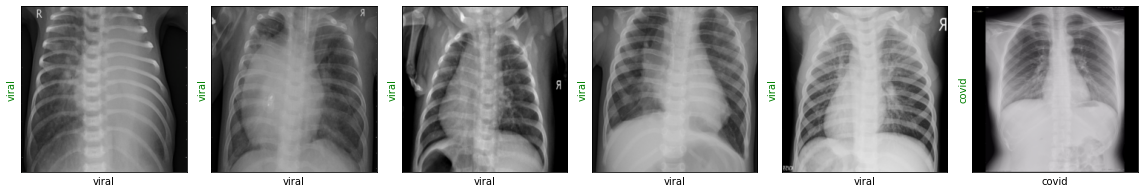

In [12]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

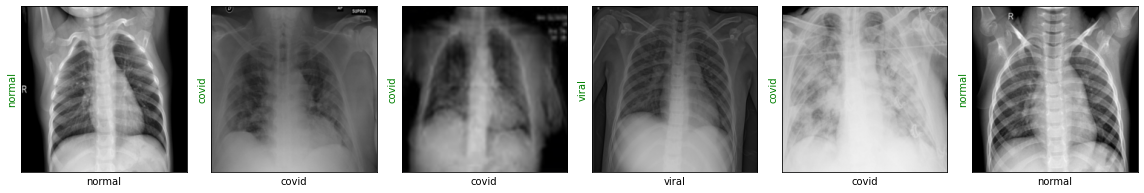

In [13]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Preparing the pretrained ResNet-18 model

In [14]:
resnet18 = torchvision.models.resnet18(pretrained = True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3)
loss_fn     = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [16]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs  = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

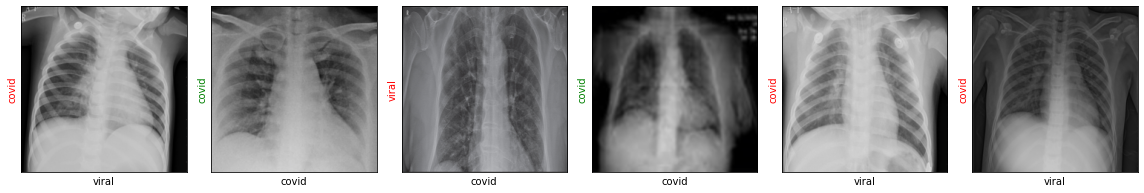

In [17]:
show_preds()

# Training and Testing the Model

In [18]:
train_loss_arr=[]
val_loss_arr=[]
accuracy_arr=[]
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                accuracy = 0
                resnet18.eval() # set model to eval phase
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = 100 * accuracy/len(test_dataset)
                val_loss_arr.append(val_loss*100)
                accuracy_arr.append(accuracy)
                print(f'Training Step: {train_step}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                #show_preds()
                resnet18.train()

                if accuracy >= 95.00 and val_loss <= 0.01:
                    print('Performance condition satisfied, stopping..')
                    return
                  
        train_loss /= (train_step + 1)
        train_loss_arr.append(train_loss)
        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [19]:
%%time

train(epochs=1)

Starting training..
Starting epoch 1/1
Training Step: 0, Validation Loss: 1.1443, Accuracy: 47.7778
Training Step: 20, Validation Loss: 0.5561, Accuracy: 87.7778
Training Step: 40, Validation Loss: 0.3440, Accuracy: 91.1111
Training Step: 60, Validation Loss: 0.2135, Accuracy: 93.3333
Training Step: 80, Validation Loss: 0.3608, Accuracy: 88.8889
Training Step: 100, Validation Loss: 0.1859, Accuracy: 93.3333
Training Step: 120, Validation Loss: 0.1947, Accuracy: 94.4444
Training Step: 140, Validation Loss: 0.2047, Accuracy: 93.3333
Training Step: 160, Validation Loss: 0.2033, Accuracy: 93.3333
Training Step: 180, Validation Loss: 0.2595, Accuracy: 91.1111
Training Step: 200, Validation Loss: 0.1507, Accuracy: 94.4444
Training Step: 220, Validation Loss: 0.1797, Accuracy: 95.5556
Training Step: 240, Validation Loss: 0.1717, Accuracy: 93.3333
Training Step: 260, Validation Loss: 0.1460, Accuracy: 94.4444
Training Step: 280, Validation Loss: 0.1091, Accuracy: 97.7778
Training Step: 300, Va

# Final Results

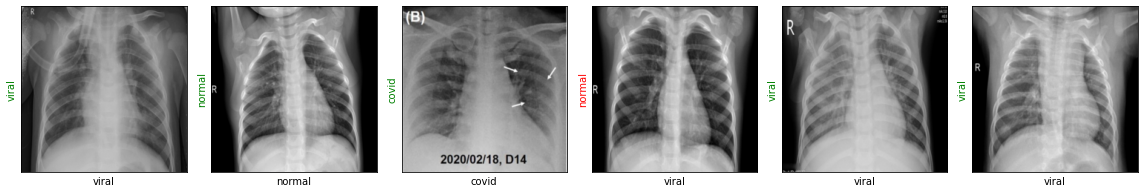

In [20]:
show_preds()

In [21]:
print("Accuracy:",accuracy_arr[-2],"%")

Accuracy: 95.55555555555556 %


In [22]:
torch.save(resnet18.state_dict(),"model.pth")

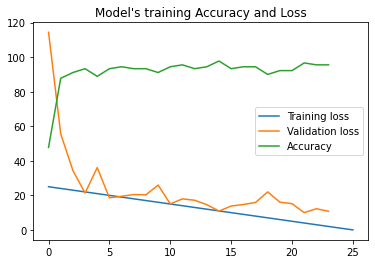

In [85]:
plt.plot(np.arange(0,train_loss_arr[0]*100,1)[::-1],label="Training loss")
plt.plot(val_loss_arr,label="Validation loss")
plt.plot(accuracy_arr,label="Accuracy")
plt.title("Model's training Accuracy and Loss")
plt.legend()